In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import style
from matplotlib import pyplot as plt
style.use(style.available[14])

In [3]:
import torch as tr
import numpy as np
np.random.seed(42)
tr.manual_seed(42)
if tr.cuda.is_available():
    tr.cuda.manual_seed_all(42)
    tr.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, SGD, RMSprop

In [5]:
from models.images.classifier import MNISTCritic, Net
from dataloaders.mnist import MnistDataLoader, FashionMnistDataLoader, MixedMnistDataLoader

In [7]:
dataset = 'mnist'

In [8]:
dl_mnist = MnistDataLoader(train_batch_size=64, test_batch_size=256)
dl_fmnist = FashionMnistDataLoader(train_batch_size=64, test_batch_size=256)
dl_mixed = MixedMnistDataLoader(train_batch_size=64, test_batch_size=256)

dl = {
    'mnist': dl_mnist,
    'fashion': dl_fmnist,
    'mixed': dl_mixed,
}[dataset]

In [9]:
from collections import Counter
Counter(dl.labels['test'].numpy())

Counter({0: 980,
         1: 1135,
         2: 1032,
         3: 1010,
         4: 982,
         5: 892,
         6: 958,
         7: 1028,
         8: 974,
         9: 1009})

In [12]:
data = dl.data['train'].numpy()
labels = dl.labels['train'].numpy()

(60000, 3, 28, 28)
(60000, 3)
[8 0 7]


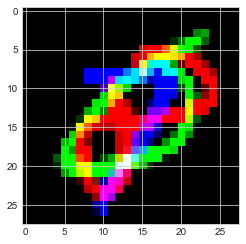

In [27]:
n = data.shape[0]
perm1 = np.random.permutation(n)
perm2 = np.random.permutation(n)
perm3 = np.random.permutation(n)

stacked_data = np.concatenate([data[perm1], data[perm2], data[perm3]], axis=1)
stacked_labels = np.array([labels[perm1], labels[perm2], labels[perm3]]).transpose([1, 0])

print stacked_data.shape
print stacked_labels.shape
plt.imshow(stacked_data[0].transpose([1, 2, 0]));
print stacked_labels[0]

In [26]:
# net = CNN()
net = MNISTCritic(20)
# net = Net()

In [35]:
x, l = dl.next_batch('train')

tensor(3)


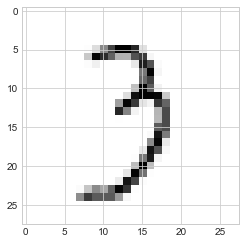

In [36]:
i = 13

plt.imshow(x[i, 0].cpu().numpy())
print l[i]

In [37]:
# opt = Adam(net.parameters(), lr=0.001)
opt = Adam(net.parameters(), lr=0.001, betas=(0.5, 0.5))
# opt = SGD(net.parameters(), lr=0.001, momentum=0.5)
# opt = RMSprop(net.parameters(), lr=0.001)
def compute_loss(img, labels):
    logits = net.forward(img)
    loss = F.nll_loss(logits, labels)
    return loss

In [38]:
net.forward(dl.next_batch('train')[0]).shape

torch.Size([64, 20])

In [45]:
def accuracy(x_batch, labels):
    preds = net.predict(x_batch, numpy=False)
    acc = 100.0 * tr.sum(labels == preds)/ x_batch.shape[0]
    return acc

def train_critic(n_iters):
    for i in range(n_iters):
        imgs, labels = dl.next_batch('train')
        
        opt.zero_grad()
        loss = compute_loss(imgs, labels)
        loss.backward()
        opt.step()
        
        with tr.no_grad():
            net.eval()
            acc = accuracy(imgs, labels)
            net.train()
        
        train_losses.append(loss.item())
        train_acc.append(acc)
        
        
        if i % 100 == 0:
            net.eval()
            with tr.no_grad():
                test_imgs, test_labels = dl.next_batch('test')
                loss = compute_loss(test_imgs, test_labels)
                tacc = accuracy(test_imgs, test_labels)
                
                test_losses.append(loss.item())
                test_acc.append(tacc)
                
                if i % 500 == 0:
                    print 'Step %d: Train Accuracy %.3f Test Accuracy %.3f' % (i, acc, tacc)
            net.train()

In [46]:
train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_critic(dl.n_batches['train'] * 25)

Step 0: Train Accuracy 29.000 Test Accuracy 21.000
Step 500: Train Accuracy 75.000 Test Accuracy 69.000
Step 1000: Train Accuracy 71.000 Test Accuracy 71.000
Step 1500: Train Accuracy 81.000 Test Accuracy 76.000
Step 2000: Train Accuracy 85.000 Test Accuracy 87.000
Step 2500: Train Accuracy 87.000 Test Accuracy 82.000
Step 3000: Train Accuracy 93.000 Test Accuracy 86.000
Step 3500: Train Accuracy 95.000 Test Accuracy 91.000
Step 4000: Train Accuracy 85.000 Test Accuracy 88.000
Step 4500: Train Accuracy 92.000 Test Accuracy 91.000
Step 5000: Train Accuracy 93.000 Test Accuracy 90.000
Step 5500: Train Accuracy 90.000 Test Accuracy 88.000
Step 6000: Train Accuracy 87.000 Test Accuracy 90.000
Step 6500: Train Accuracy 95.000 Test Accuracy 95.000
Step 7000: Train Accuracy 96.000 Test Accuracy 92.000
Step 7500: Train Accuracy 98.000 Test Accuracy 94.000
Step 8000: Train Accuracy 98.000 Test Accuracy 95.000
Step 8500: Train Accuracy 95.000 Test Accuracy 91.000
Step 9000: Train Accuracy 96.000

KeyboardInterrupt: 

In [47]:
log_probs = net.forward(dl.next_batch('test')[0])
probs = tr.exp(log_probs)
probs = probs.detach().cpu().numpy()
# freq = Counter(preds)

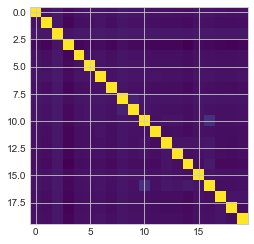

In [48]:
plt.imshow(np.corrcoef(probs.T), cmap='viridis')

In [49]:
tr.save(net.state_dict(), 'mnist_mix_clf_best.pt')
# tr.save(net.state_dict(), 'mnist_clf.pt')
# net2 = Net()
# net2.load_state_dict(tr.load('model.pth'))

In [54]:
# net_ = net
# net = net2
net.eval()
accuracy(*dl.random_batch('train', 1024))

tensor(98)

In [19]:
plt.plot(train_losses[:, 0], train_losses[:, 1])
plt.plot(test_losses[:, 0], test_losses[:, 1])

TypeError: list indices must be integers, not tuple

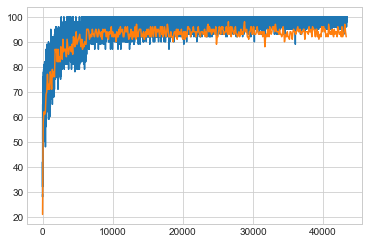

In [62]:
plt.plot(train_acc)
plt.plot(np.arange(0, len(train_acc), 100), test_acc)

In [29]:
Z = np.random.normal(0, 1, (1000, 100))

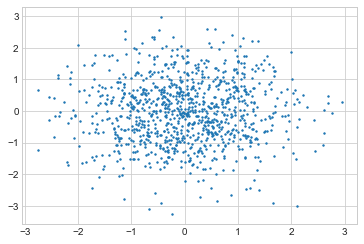

In [35]:
plt.scatter(Z[:, 4], Z[:, 23], s=2

In [68]:
Z = np.random.normal(0, 2, (1000, 12))
C =np.cov(Z.T)

In [69]:
from sklearn.mixture import GaussianMixture

In [70]:
gmm = GaussianMixture(2)

In [71]:
gmm.fit(Z)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

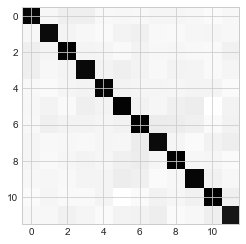

In [72]:
from utils import  viz_utils
plt.imshow(C);

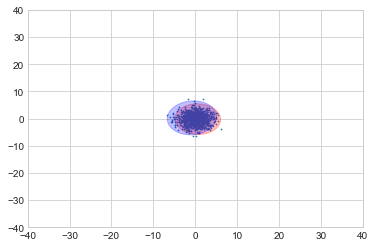

In [73]:
ax = plt.gca()
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

viz_utils.scatter_2d(ax, Z[:, 3:5])

viz_utils.plot_ellipse(ax, gmm.means_[0][:2], gmm.covariances_[0][:2, :2]);
viz_utils.plot_ellipse(ax, gmm.means_[1][:2], gmm.covariances_[1][:2, :2], color='blue');